In [ ]:
from keras.models import Sequential
from keras.layers import Dense 
from keras.layers import Flatten 
import tensorflow as tf

# Import Meteostat library and dependencies
from datetime import datetime
from meteostat import Hourly
from meteostat import Point

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# https://dontrepeatyourself.org/post/save-and-load-models-with-tensorflow/


model = tf.keras.models.load_model("w_model", compile = True)

In [3]:

# Create Point for San Diego: 32.7338° N, 117.1933° W
sd = Point(32.7338, 117.1933)

In [4]:
# script to get data of requested city in recent days


# data units
# ① Humidity (%), ② Pressure (hPa), ③ Temperature (K), 4) Wind Speed (m/s).

# sd coordinates: 32.7157° N, 117.1611° W


# Set time period
start = datetime(2023, 4, 4)
end = datetime(2023, 4, 23, 23, 59)

# Get hourly data
data = Hourly(sd, start, end)
data = data.fetch()

# Print DataFrame
actualData = data[['temp','pres','rhum','wspd']]


def f(x):
    x = x + 273.15
    return float(x)


actualData['temp'] = actualData['temp'].map(lambda a: a+273.15)
actualData

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,temp,pres,rhum,wspd
time,,,,
2023-04-04 00:00:00,286.25,1004.8,97.0,7.4
2023-04-04 01:00:00,286.55,1005.3,96.0,9.3
2023-04-04 02:00:00,286.95,1005.9,95.0,13.0
2023-04-04 03:00:00,287.25,1006.4,94.0,14.8
2023-04-04 04:00:00,287.95,1006.1,93.0,14.8
...,...,...,...,...
2023-04-23 19:00:00,282.15,1024.3,86.0,14.8
2023-04-23 20:00:00,282.05,1024.3,86.0,14.8
2023-04-23 21:00:00,281.95,1024.4,86.0,14.8


In [5]:
features = actualData

training_size = int (0.8*features.shape[0])  

dataset=features.values
data_mean = dataset[:training_size].mean(axis=0)
data_std = dataset[:training_size].std(axis=0)
dataset = (dataset-data_mean)/data_std

dataset.shape

dataset=dataset.astype(float)

In [6]:
past_history = 48
future_target = 24
STEP = 1

In [7]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [8]:
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 training_size, past_history,
                                                 future_target, STEP)

x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             training_size, None, past_history,
                                             future_target, STEP)

print(x_train_multi.shape)
print(y_train_multi.shape)

(336, 48, 4)
(336, 24)


In [9]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (48, 4)

 Target temperature to predict : (24,)


In [10]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [11]:
predictionsPrint = np.array(0);

def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
    
    predictionsPrint = np.arange(num_out)/STEP
    print(np.array(prediction))
  plt.legend(loc='upper left')
  plt.show()

In [12]:
def create_time_steps(length):
  return list(range(-length, 0))

2023-04-23 17:03:02.974882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [24,24]
	 [[{{node Placeholder/_1}}]]
2023-04-23 17:03:03.295177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-23 17:03:03.296828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor '

1/1 [==============================] - 1s 771ms/step
[1.1562923  1.1472976  1.1883302  1.1909505  1.1223464  1.0881457
 1.1648929  0.9856081  1.1075536  1.0679374  1.0018749  0.89209867
 1.0375373  1.0058967  1.0106287  0.93270427 0.823923   0.93591315
 0.97812086 0.94638455 0.8636041  0.77789867 0.8390935  0.80226016]


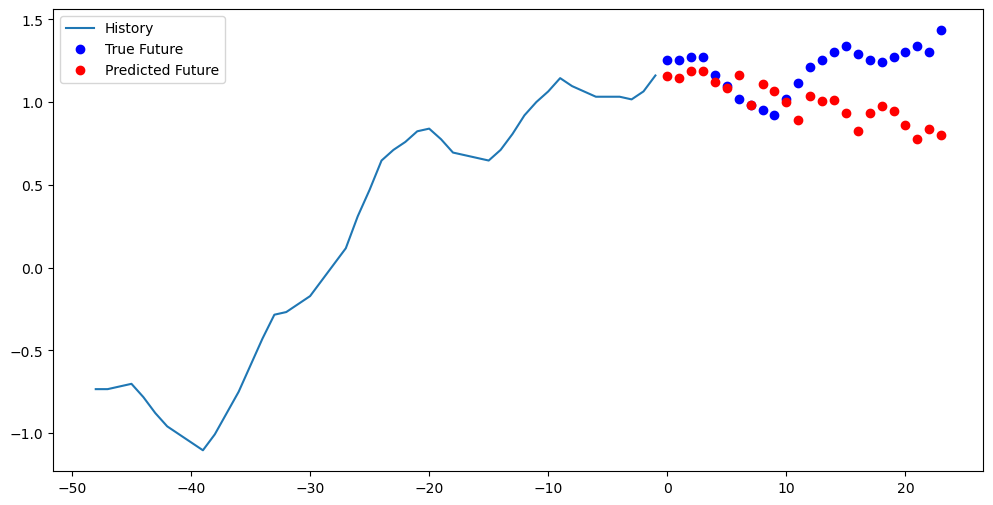

In [13]:
for x, y in val_data_multi.take(1):
  multi_step_plot(x[0], y[0], model.predict(x)[0])

# print(model.predict(x_train_multi))



In [14]:
# print(model.predict(x))


In [15]:

def plot_test(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
    
  plt.legend(loc='upper left')
  plt.show()

1/1 [==============================] - 0s 27ms/step


2023-04-23 17:03:04.007029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [24,24]
	 [[{{node Placeholder/_1}}]]


[1.1562923  1.1472976  1.1883302  1.1909505  1.1223464  1.0881457
 1.1648929  0.9856081  1.1075536  1.0679374  1.0018749  0.89209867
 1.0375373  1.0058967  1.0106287  0.93270427 0.823923   0.93591315
 0.97812086 0.94638455 0.8636041  0.77789867 0.8390935  0.80226016]


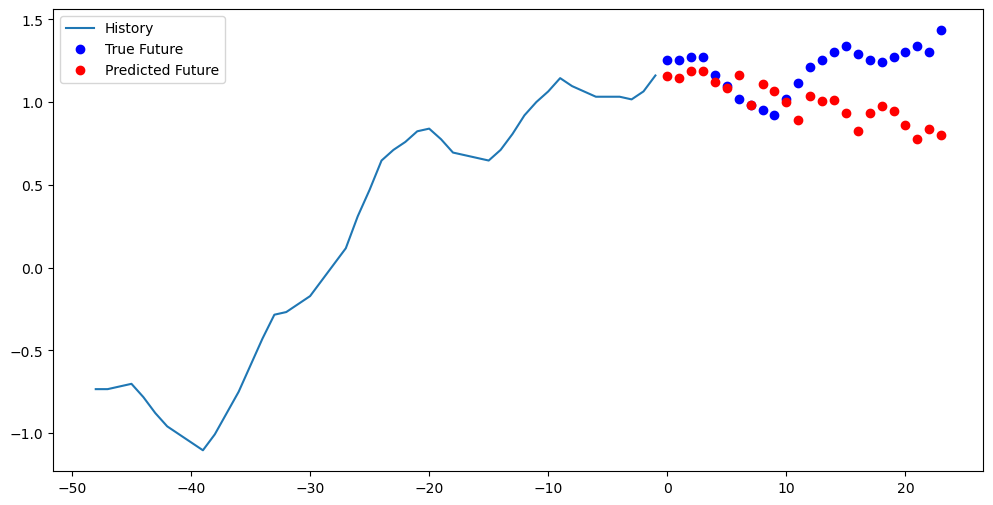

In [16]:
for x, y in val_data_multi.take(1):
  multi_step_plot(x[0], y[0], model.predict(x)[0])


In [17]:
def denormalize(a):
    #     data_mean = dataset[:training_size].mean(axis=0)
    #     data_std = dataset[:training_size].std(axis=0)
    #     dataset = (dataset-data_mean)/data_std
    return a*data_std[0]+data_mean[0]-273.15

denorm = np.vectorize(denormalize)
predictAns = np.array(model.predict(x)[0])
print(denorm(predictAns))

# data_mean[]

1/1 [==============================] - 0s 25ms/step
[24.01749837 23.9677109  24.19483435 24.20933845 23.82960088 23.64029329
 24.06510438 23.07272684 23.74771975 23.52843595 23.16276698 22.55513328
 23.36016562 23.18502826 23.2112209  22.77989348 22.1777672  22.79765526
 23.03128348 22.85561659 22.39741028 21.92301331 22.26173905 22.05785907]


[24.01749837 23.9677109  24.19483435 24.20933845 23.82960088 23.64029329
 24.06510438 23.07272684 23.74771975 23.52843595 23.16276698 22.55513328
 23.36016562 23.18502826 23.2112209  22.77989348 22.1777672  22.79765526
 23.03128348 22.85561659 22.39741028 21.92301331 22.26173905 22.05785907]


2023-04-23 17:03:04.320271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [24,24]
	 [[{{node Placeholder/_1}}]]


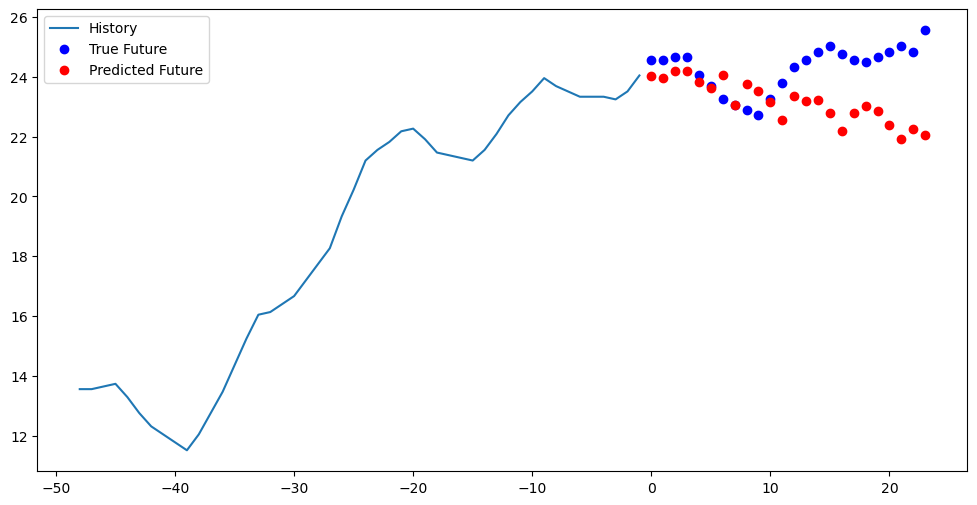

[24.01749837 23.9677109  24.19483435 24.20933845 23.82960088 23.64029329
 24.06510438 23.07272684 23.74771975 23.52843595 23.16276698 22.55513328
 23.36016562 23.18502826 23.2112209  22.77989348 22.1777672  22.79765526
 23.03128348 22.85561659 22.39741028 21.92301331 22.26173905 22.05785907]


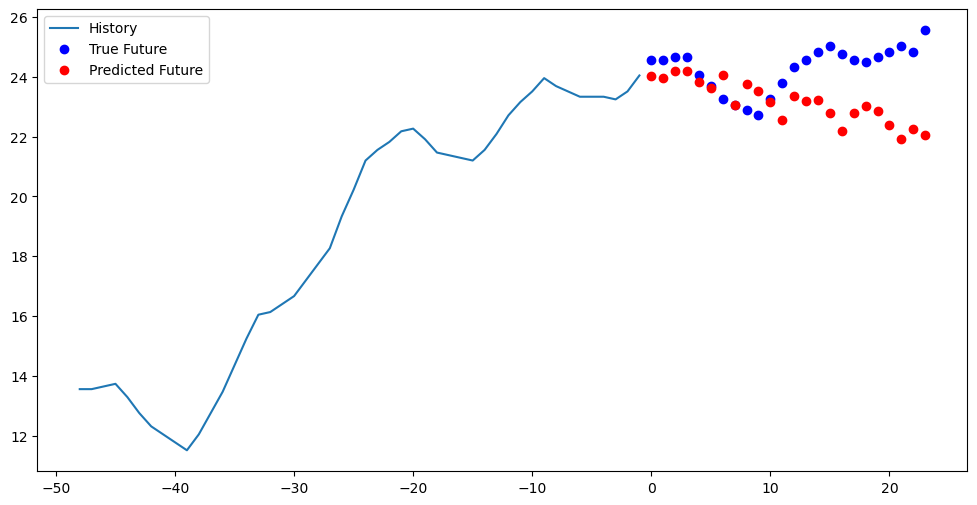

[24.01749837 23.9677109  24.19483435 24.20933845 23.82960088 23.64029329
 24.06510438 23.07272684 23.74771975 23.52843595 23.16276698 22.55513328
 23.36016562 23.18502826 23.2112209  22.77989348 22.1777672  22.79765526
 23.03128348 22.85561659 22.39741028 21.92301331 22.26173905 22.05785907]


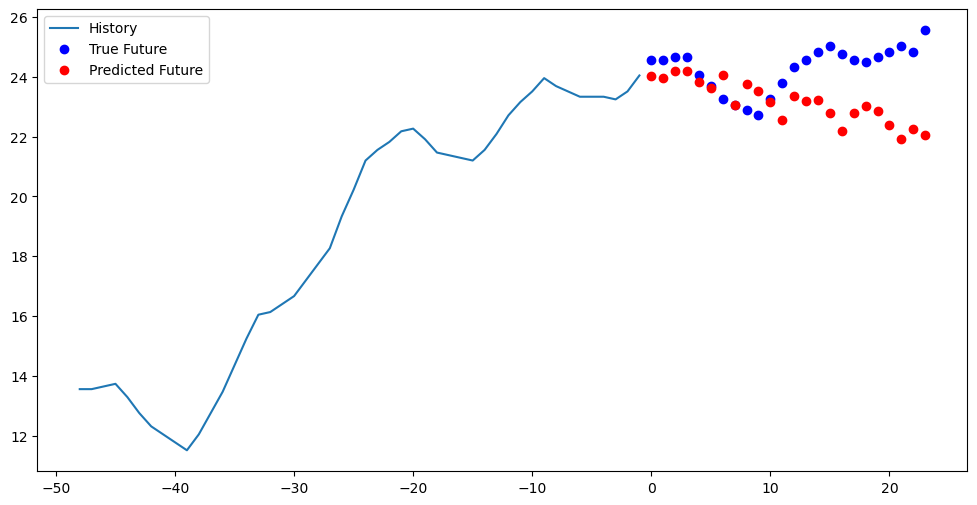

[24.01749837 23.9677109  24.19483435 24.20933845 23.82960088 23.64029329
 24.06510438 23.07272684 23.74771975 23.52843595 23.16276698 22.55513328
 23.36016562 23.18502826 23.2112209  22.77989348 22.1777672  22.79765526
 23.03128348 22.85561659 22.39741028 21.92301331 22.26173905 22.05785907]


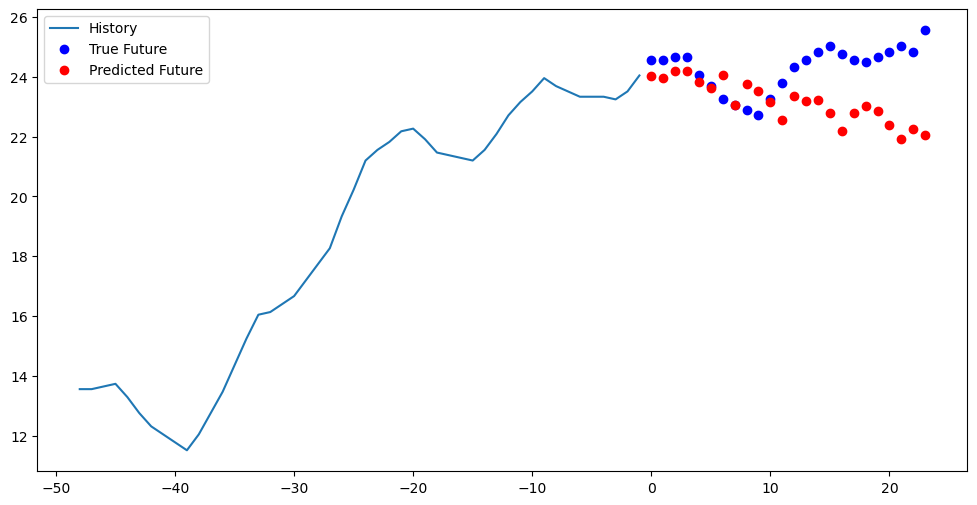

[24.01749837 23.9677109  24.19483435 24.20933845 23.82960088 23.64029329
 24.06510438 23.07272684 23.74771975 23.52843595 23.16276698 22.55513328
 23.36016562 23.18502826 23.2112209  22.77989348 22.1777672  22.79765526
 23.03128348 22.85561659 22.39741028 21.92301331 22.26173905 22.05785907]


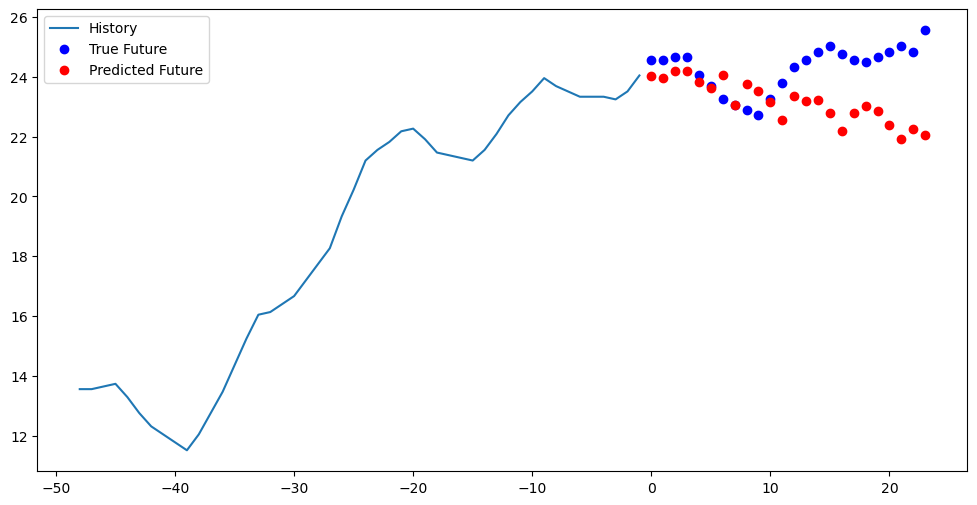

[24.01749837 23.9677109  24.19483435 24.20933845 23.82960088 23.64029329
 24.06510438 23.07272684 23.74771975 23.52843595 23.16276698 22.55513328
 23.36016562 23.18502826 23.2112209  22.77989348 22.1777672  22.79765526
 23.03128348 22.85561659 22.39741028 21.92301331 22.26173905 22.05785907]


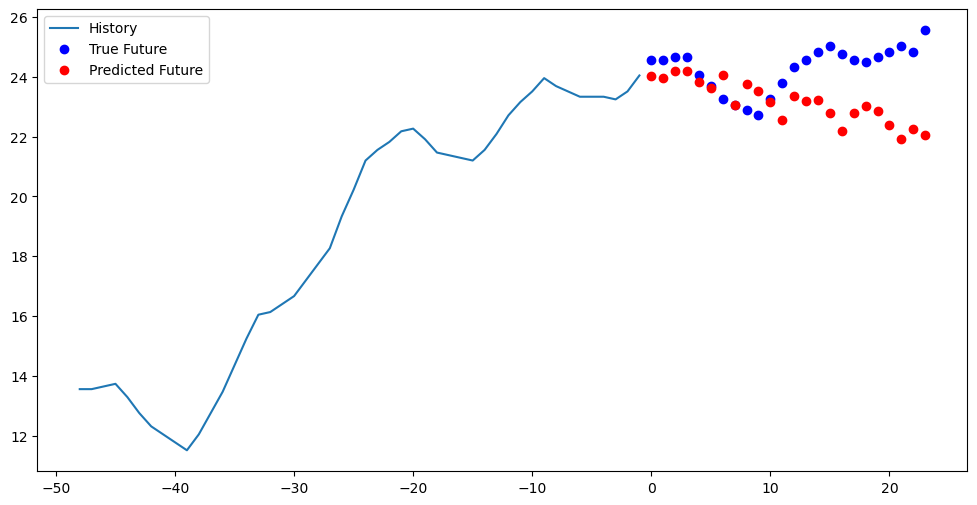

[24.01749837 23.9677109  24.19483435 24.20933845 23.82960088 23.64029329
 24.06510438 23.07272684 23.74771975 23.52843595 23.16276698 22.55513328
 23.36016562 23.18502826 23.2112209  22.77989348 22.1777672  22.79765526
 23.03128348 22.85561659 22.39741028 21.92301331 22.26173905 22.05785907]


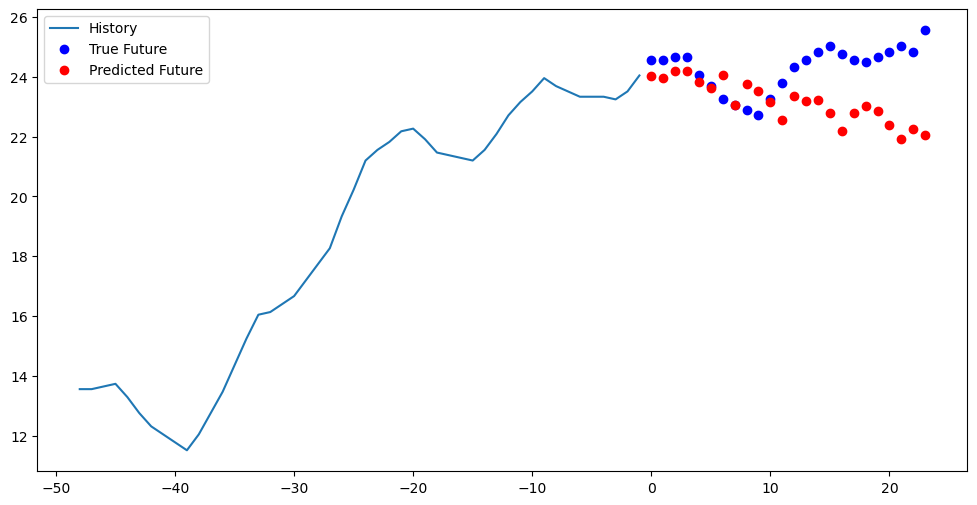

[24.01749837 23.9677109  24.19483435 24.20933845 23.82960088 23.64029329
 24.06510438 23.07272684 23.74771975 23.52843595 23.16276698 22.55513328
 23.36016562 23.18502826 23.2112209  22.77989348 22.1777672  22.79765526
 23.03128348 22.85561659 22.39741028 21.92301331 22.26173905 22.05785907]


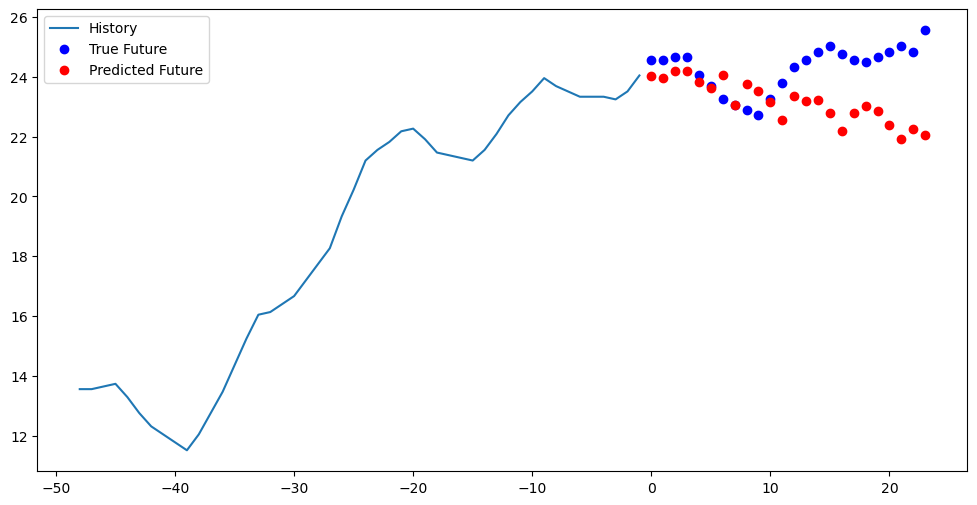

[24.01749837 23.9677109  24.19483435 24.20933845 23.82960088 23.64029329
 24.06510438 23.07272684 23.74771975 23.52843595 23.16276698 22.55513328
 23.36016562 23.18502826 23.2112209  22.77989348 22.1777672  22.79765526
 23.03128348 22.85561659 22.39741028 21.92301331 22.26173905 22.05785907]


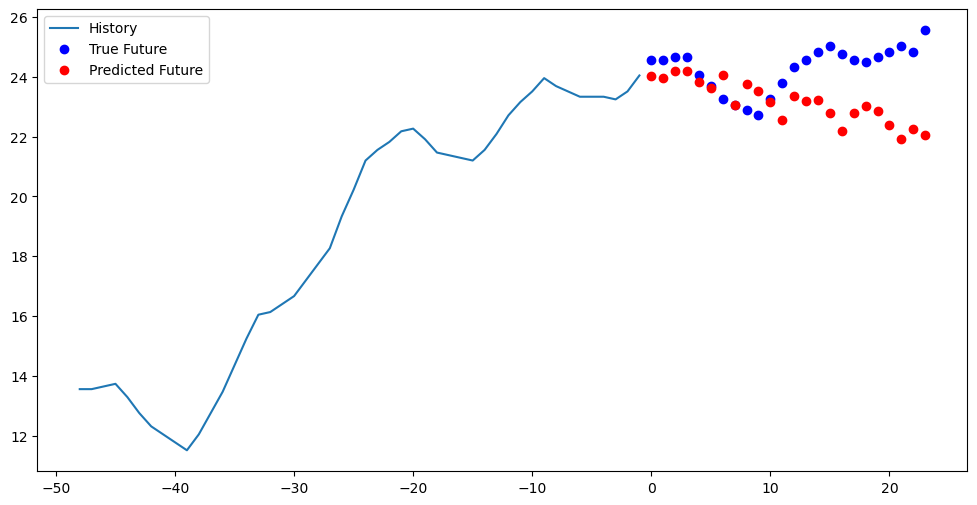

[24.01749837 23.9677109  24.19483435 24.20933845 23.82960088 23.64029329
 24.06510438 23.07272684 23.74771975 23.52843595 23.16276698 22.55513328
 23.36016562 23.18502826 23.2112209  22.77989348 22.1777672  22.79765526
 23.03128348 22.85561659 22.39741028 21.92301331 22.26173905 22.05785907]


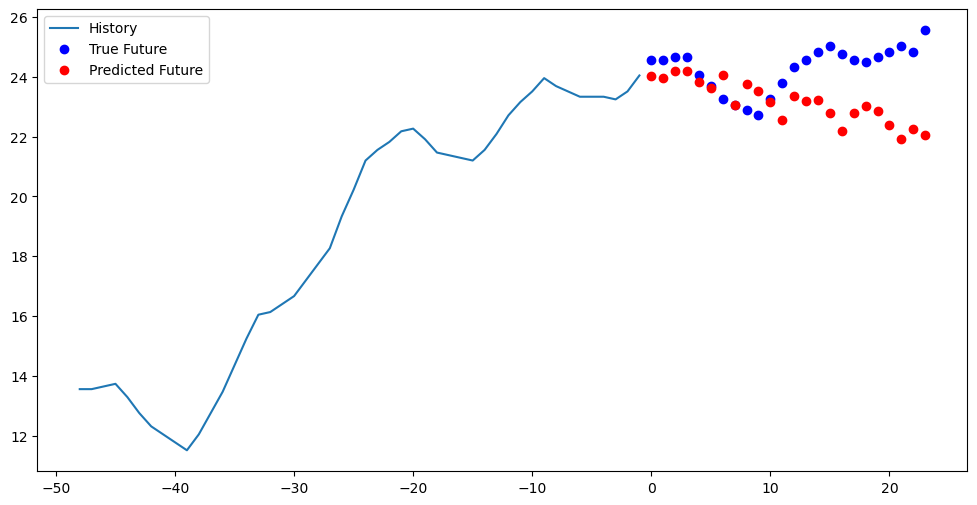

[24.01749837 23.9677109  24.19483435 24.20933845 23.82960088 23.64029329
 24.06510438 23.07272684 23.74771975 23.52843595 23.16276698 22.55513328
 23.36016562 23.18502826 23.2112209  22.77989348 22.1777672  22.79765526
 23.03128348 22.85561659 22.39741028 21.92301331 22.26173905 22.05785907]


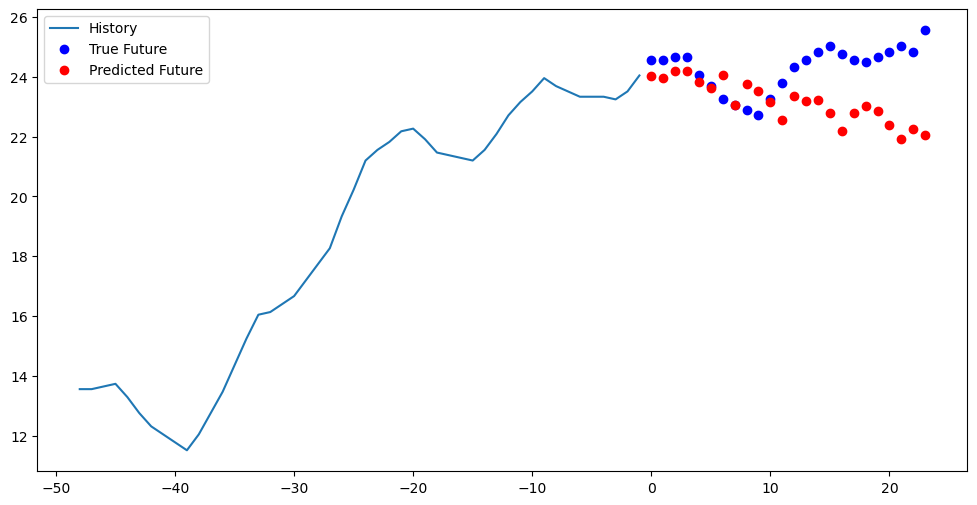

[24.01749837 23.9677109  24.19483435 24.20933845 23.82960088 23.64029329
 24.06510438 23.07272684 23.74771975 23.52843595 23.16276698 22.55513328
 23.36016562 23.18502826 23.2112209  22.77989348 22.1777672  22.79765526
 23.03128348 22.85561659 22.39741028 21.92301331 22.26173905 22.05785907]


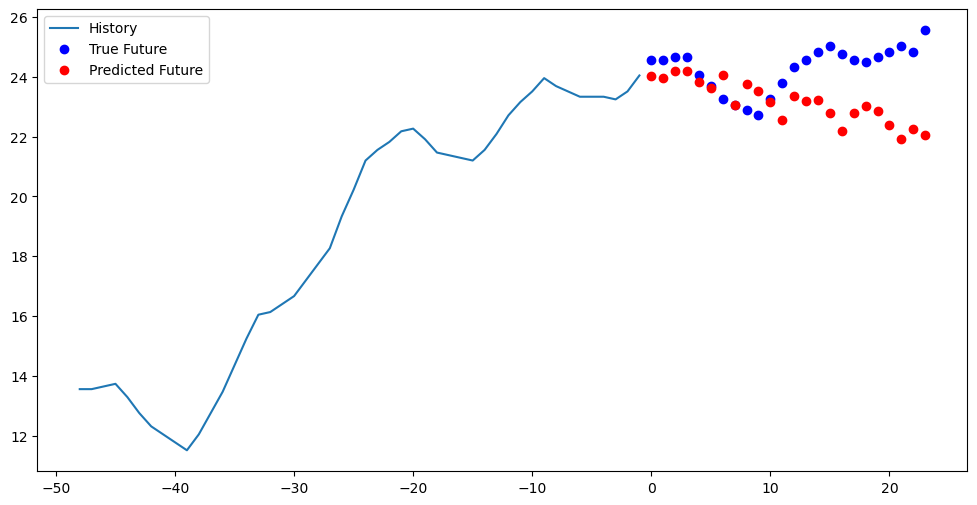

[24.01749837 23.9677109  24.19483435 24.20933845 23.82960088 23.64029329
 24.06510438 23.07272684 23.74771975 23.52843595 23.16276698 22.55513328
 23.36016562 23.18502826 23.2112209  22.77989348 22.1777672  22.79765526
 23.03128348 22.85561659 22.39741028 21.92301331 22.26173905 22.05785907]


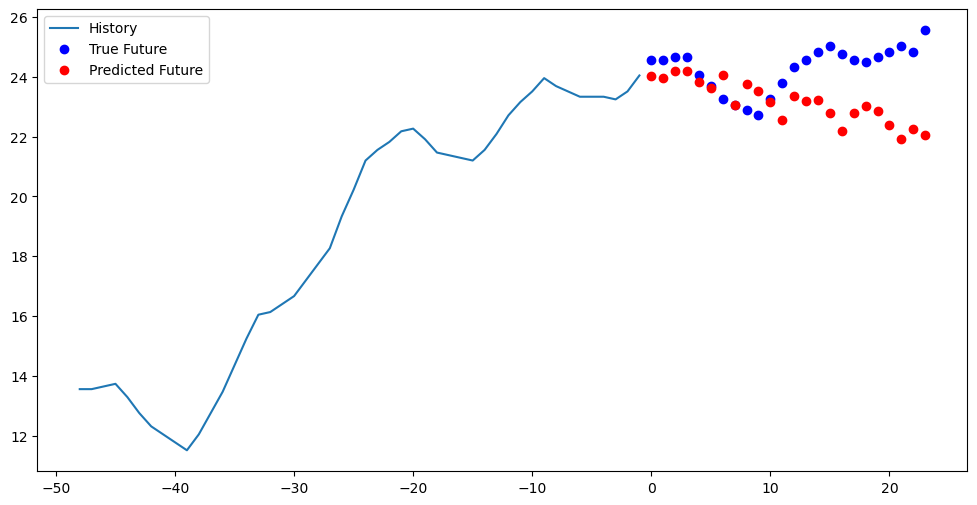

[24.01749837 23.9677109  24.19483435 24.20933845 23.82960088 23.64029329
 24.06510438 23.07272684 23.74771975 23.52843595 23.16276698 22.55513328
 23.36016562 23.18502826 23.2112209  22.77989348 22.1777672  22.79765526
 23.03128348 22.85561659 22.39741028 21.92301331 22.26173905 22.05785907]


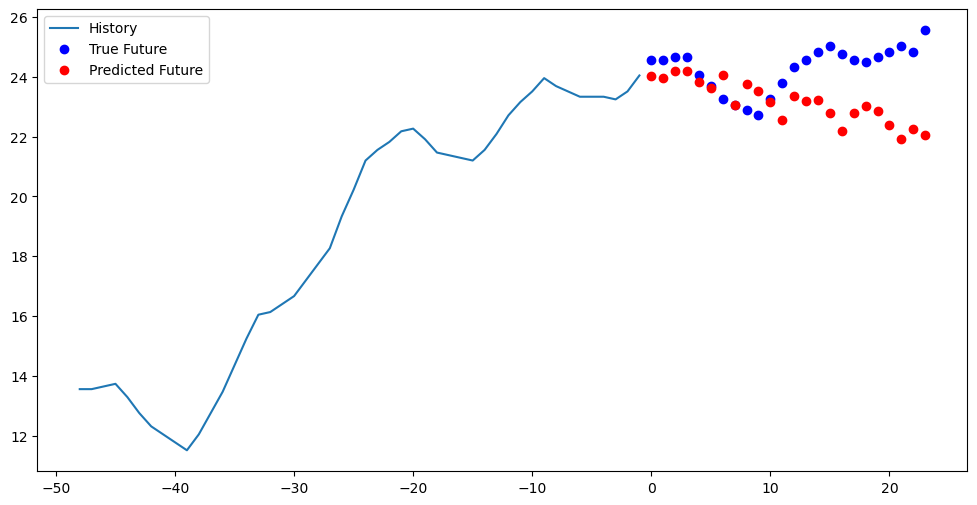

[24.01749837 23.9677109  24.19483435 24.20933845 23.82960088 23.64029329
 24.06510438 23.07272684 23.74771975 23.52843595 23.16276698 22.55513328
 23.36016562 23.18502826 23.2112209  22.77989348 22.1777672  22.79765526
 23.03128348 22.85561659 22.39741028 21.92301331 22.26173905 22.05785907]


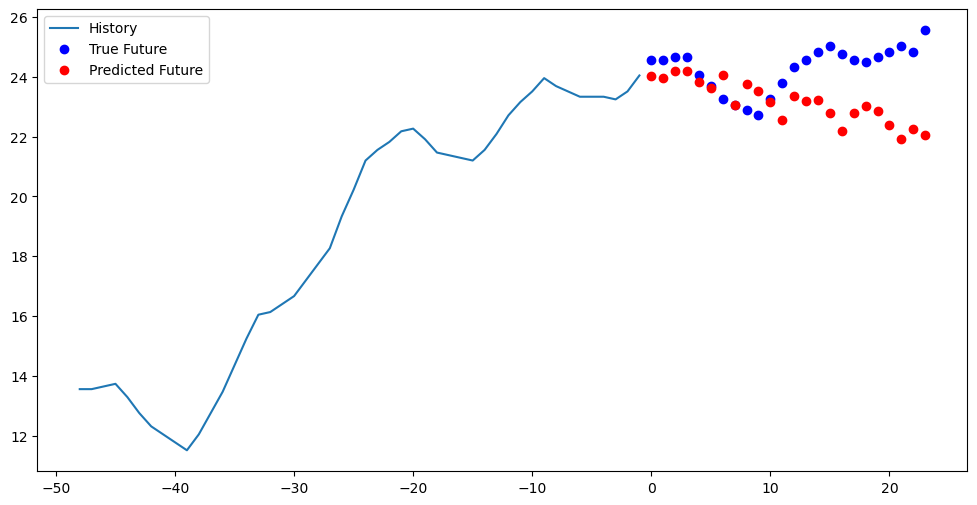

In [18]:
for x, y in val_data_multi.take(15):
  multi_step_plot(denorm(x[0]), denorm(y[0]), denorm(predictAns))